# Fundamentos de analítica 2 (clase 3)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com

## **1. Carga de paquetes**

In [25]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

## **2. Carga de datos**



In [26]:
data = pd.read_excel(r'https://github.com/alfa7g7/Fundamentos-analitica-II/raw/main/Clase%201/Ejercicio%20en%20clase.-20240802/datosEmpleo.xlsx', index_col='mes', parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(220, 4)


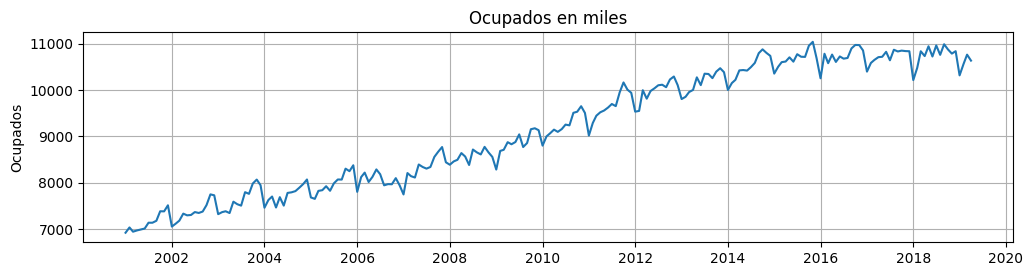

In [27]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Ocupados en miles")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

Protocolos de evaluación:

In [28]:
# Separar los datos en entrenamiento y prueba
horizon = 6 # El numero de pronósitco que queremos hacer hacia el futuro
train_len = len(data)- horizon
data_train = data.iloc[:train_len]
data_test = data.iloc[train_len:]

In [29]:
data_train

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2018-06-01,11.071347,10720.946,1334.725,6101.948
2018-07-01,10.125100,10959.197,1234.638,5984.340
2018-08-01,10.085244,10756.782,1206.529,6235.352


In [30]:
data_test

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2018-11-01,9.844539,10783.299,1177.484,6298.992
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575


## **3. ACF y PACF**

In [31]:
acf(data_train['Ocupados'],80) # es el numero de resagos

array([ 1.        ,  0.97791615,  0.96080801,  0.94667826,  0.93331952,
        0.92246288,  0.90890425,  0.89895712,  0.88616889,  0.87708222,
        0.87157593,  0.86626345,  0.86077083,  0.84142836,  0.82399124,
        0.8082148 ,  0.79697724,  0.78604389,  0.77291991,  0.76236066,
        0.74958796,  0.73837173,  0.73113649,  0.72434815,  0.7167177 ,
        0.69754163,  0.67796414,  0.66216212,  0.64826997,  0.63651197,
        0.62190178,  0.60943523,  0.59693407,  0.58423665,  0.57711519,
        0.57028981,  0.5606386 ,  0.53938066,  0.52087047,  0.50524286,
        0.49022537,  0.47732197,  0.46116269,  0.44869072,  0.4338035 ,
        0.42032113,  0.41028   ,  0.40035637,  0.38982644,  0.36876455,
        0.34815665,  0.331989  ,  0.31818874,  0.3052246 ,  0.28935639,
        0.27664314,  0.26282466,  0.25123173,  0.24267572,  0.23345379,
        0.22375204,  0.20333509,  0.18758961,  0.17295868,  0.15982591,
        0.14786426,  0.13436311,  0.12309555,  0.10875995,  0.09

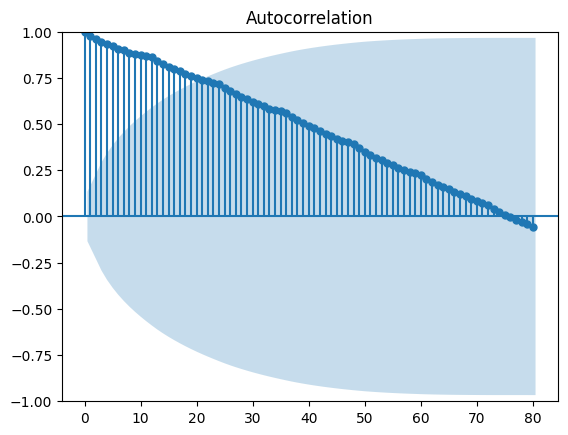

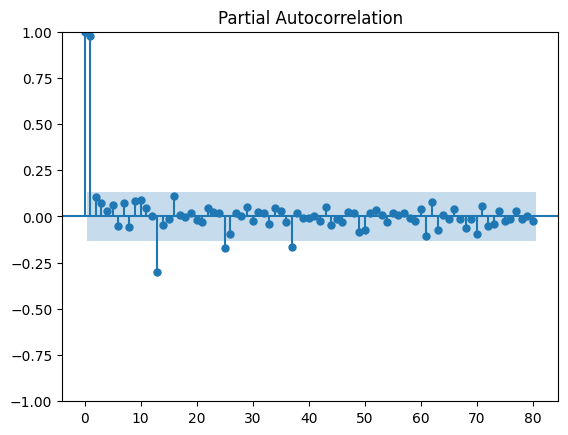

In [32]:
plot_acf(data_train['Ocupados'],lags=80);
plot_pacf(data_train['Ocupados'],lags=80);

<Figure size 1200x600 with 0 Axes>

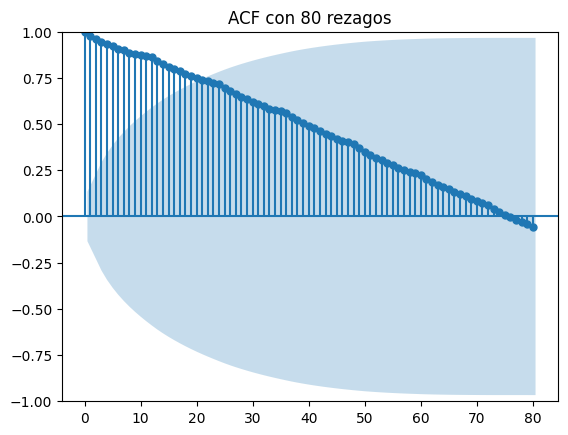

<Figure size 1200x600 with 0 Axes>

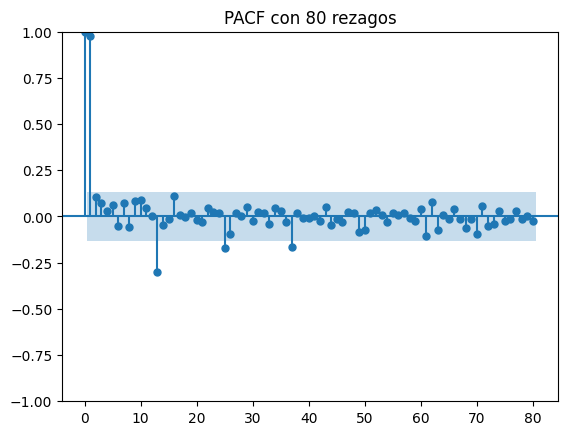

In [33]:
# Calcular y graficar ACF
plt.figure(figsize=(12, 6))
plot_acf(data_train['Ocupados'], lags=80)
plt.title('ACF con 80 rezagos')
plt.show()

# Calcular y graficar PACF
plt.figure(figsize=(12, 6))
plot_pacf(data_train['Ocupados'], lags=80)
plt.title('PACF con 80 rezagos')
plt.show()


ARIMA con "aic"

In [34]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(data_train["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Sat, 17 Aug 2024   AIC                           2800.549
Time:                        12:13:29   BIC                           2813.994
Sample:                    01-01-2001   HQIC                          2805.983
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3401      2.394      4.320      0.000       5.648      15.032
ar.L1          0.4455      0.096      4.657      0.000       0.258       0.633
ma.L1         -0.8728      0.048    -18.169      0.000      -0.967      -0.779
sigma2      2.871e+04   2475.423     11.598      0.000    2.39e+04    3.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                48.07
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.93
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model.resid()

mes
2001-01-01    6904.955213
2001-02-01     157.874091
2001-03-01     -40.468263
2001-04-01      26.666541
2001-05-01      20.251385
                 ...     
2018-06-01    -197.962151
2018-07-01     153.306792
2018-08-01    -185.101577
2018-09-01     146.436429
2018-10-01     -94.770743
Length: 214, dtype: float64

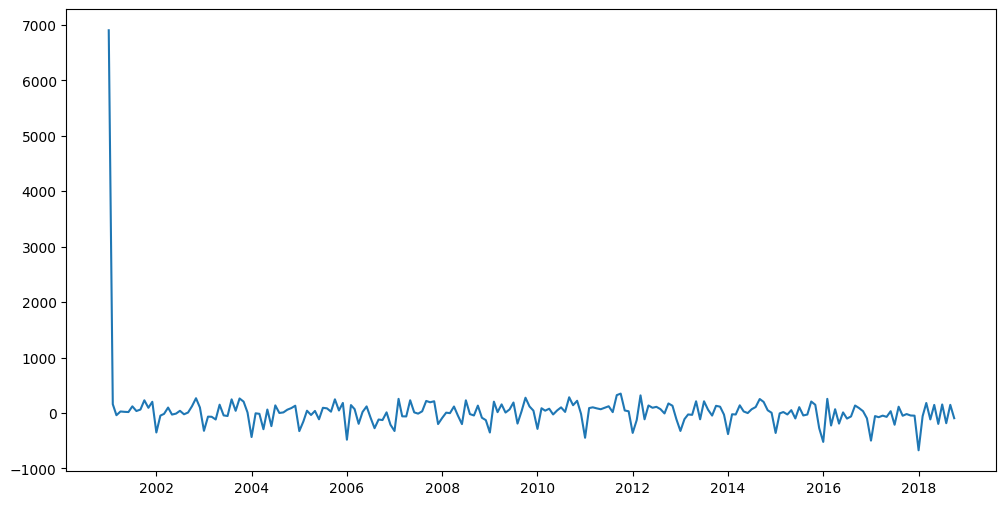

In [36]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid(),label="Residuales")

Buscando el mejor modelo ARIMA:

El criterio AIC no es aplicable: 'ARIMA' object has no attribute 'aic_'
El criterio BIC no es aplicable: 'ARIMA' object has no attribute 'bic_'
El criterio HQIC no es aplicable: 'ARIMA' object has no attribute 'hqic_'
El criterio AICC no es aplicable: 'ARIMA' object has no attribute 'aicc_'


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Modelo con criterio OOB:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Sat, 17 Aug 2024   AIC                           2800.549
Time:                        12:20:00   BIC                           2813.994
Sample:                    01-01-2001   HQIC                          2805.983
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3401      2.394      4.320      0.000       5.648      15.032
ar.L1          0.4455      0.096      4.657      0.000       0.258       0.633
ma.L1         -0.8728      

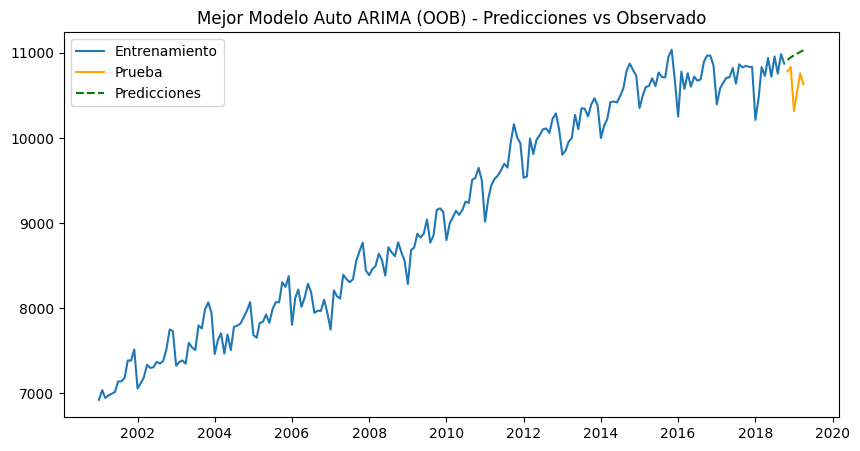

In [39]:
# Lista de criterios de información a probar
criterios = ["aic", "bic", "hqic", "aicc", "oob"]

# Diccionario para almacenar los resultados
modelos = {}

for criterio in criterios:
    try:
        # Entrenar el modelo Auto ARIMA con el criterio actual
        modelo = auto_arima(data_train["Ocupados"], 
                            max_p=10, 
                            max_q=10, 
                            information_criterion=(criterio), 
                            seasonal=False, 
                            trace=False, 
                            stepwise=True, 
                            suppress_warnings=True)

        # Obtener el valor del criterio para el modelo entrenado
        valor_criterio = getattr(modelo, f'{criterio}_') if criterio in ['aic', 'bic', 'hqic', 'aicc'] else modelo.oob()

        # Almacenar el modelo y su valor de criterio
        modelos[criterio] = {
            'modelo': modelo,
            'valor_criterio': valor_criterio
        }

        # Mostrar el resumen del modelo para cada criterio
        print(f"Modelo con criterio {criterio.upper()}:")
        print(modelo.summary())
        print("\n" + "="*80 + "\n")

    except AttributeError as e:
        print(f"El criterio {criterio.upper()} no es aplicable: {e}")

# Encontrar el mejor modelo basado en el valor más bajo del criterio
mejor_criterio = min(modelos, key=lambda k: modelos[k]['valor_criterio'])
mejor_modelo = modelos[mejor_criterio]['modelo']

print(f"El mejor modelo fue seleccionado usando el criterio {mejor_criterio.upper()}.\n")

# Realizar predicciones con el mejor modelo
predicciones = mejor_modelo.predict(n_periods=6)

# Crear un DataFrame con las predicciones y las observaciones reales
predicciones_df = pd.DataFrame({'Fecha': data_test.index, 
                                'Predicciones': predicciones, 
                                'Observado': data_test['Ocupados']}).set_index('Fecha')

print(predicciones_df)

# Graficar las predicciones
plt.figure(figsize=(10, 5))
plt.plot(data_train.index, data_train['Ocupados'], label='Entrenamiento')
plt.plot(data_test.index, data_test['Ocupados'], label='Prueba', color='orange')
plt.plot(predicciones_df.index, predicciones_df['Predicciones'], label='Predicciones', color='green', linestyle='--')
plt.legend()
plt.title(f'Mejor Modelo Auto ARIMA ({mejor_criterio.upper()}) - Predicciones vs Observado')
plt.show()


## **4. Pronóstico del ARIMA(1,1,1) obtenido en el auto.arima**


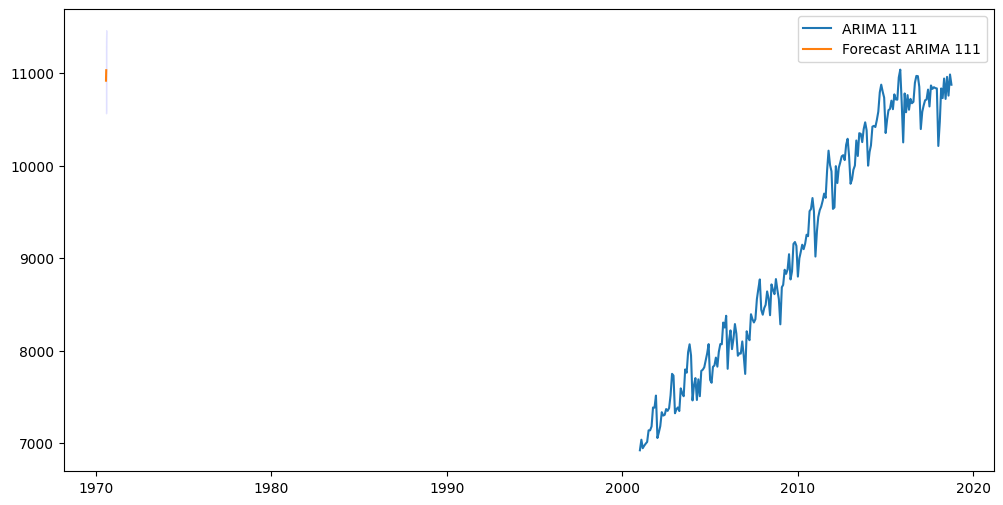

In [17]:
h=6

y_forec, conf_int  = model.predict(h, return_conf_int=True, alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec, conf_int[:,0] , conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

x_for= np.linspace((data_train.shape[0]+1),(data_train.shape[0]+h),h)

fig = plt.figure(figsize=(12, 6))
#plt.plot(data_train.index, data_train["Ocupados"],label="ARIMA 111")
plt.plot(data_train["Ocupados"], label="ARIMA 111")
plt.plot(x_for, preds['Point_forecast'], label="Forecast ARIMA 111")
plt.fill_between(x_for, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()


## **5. Replicando el modelo sin hacer auto arima**

In [11]:
model = ARIMA(order=(0,1,1))
results = model.fit( data["ARIMA011"])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  101
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -152.348
Date:                Sat, 17 Aug 2024   AIC                            310.695
Time:                        07:24:22   BIC                            318.511
Sample:                             0   HQIC                           313.858
                                - 101                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4366      0.207      2.105      0.035       0.030       0.843
ma.L1          0.8592      0.062     13.960      0.000       0.739       0.980
sigma2         1.2161      0.200      6.077      0.000       0.824       1.608
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.47   Prob(JB):                         0.50
Heteroskedasticity (H):               1.04   Skew:                            -0.16
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **6. Intervalos de confianza usando boostrap**


In [12]:
h= 10
res = results.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0) 

fore = results.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

preds


,Point_forecast,lower_95,upper_95
0,44.095552,42.050426,46.11844
1,44.532141,39.869395,48.56129
2,44.968731,38.195520,51.00414
3,45.405321,36.797624,53.24494
4,45.841911,35.189088,55.68779
5,46.278500,33.515213,58.13064
6,46.715090,31.334182,60.57349
7,47.151680,29.660308,63.01634
8,47.588270,27.986433,65.45919
9,48.024859,26.376264,67.90204


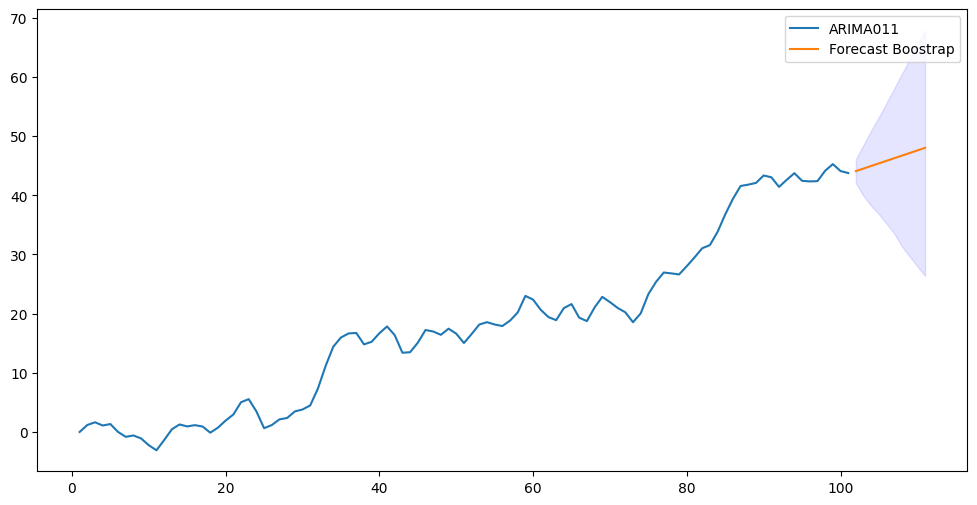

In [13]:
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)

fig = plt.figure(figsize=(12, 6))
plt.plot(data["time"],data["ARIMA011"],label="ARIMA011")
plt.plot(x_for,preds['Point_forecast'],label="Forecast Boostrap")
plt.fill_between(x_for,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **7. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. 

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.